# Recurrent neural networks

## Motivation

Up to now we used neural networks to learn functions that predicted a desired output $y$ based on an input vector $x$. We have assumed that $x$ has a constant size, such as an image of a given resolution.

In contrast, recurrent networks can be applied to sequences of different length.

Consider the problem of computing the parity checksum of a sequence of bits. Traditional neural networks that we know can not be applied to bit sequences of arbitrary length, yet a program which reads in the sequence bit-by-bit is very easy to write. 

Another motivating example is sequence generation, such as generating text or music. Again, normal neural networks that take a fixed input size are not directly applicable to whole sequences.

## Autoregressive models

An autoregressive model assumes, that the $i$-th element of a sequence depends only on a few preceding sequence elements. Lets first write the exact probability of observing a sequence $\mathbf{Y} = [Y_1, Y_2, \ldots, Y_m]$:

$$
    P(\mathbf{Y}) = P(Y_1)P(Y_2|Y_1)P(Y_3|Y_1, Y_2)\ldots P(Y_m|Y1,Y_2,\ldots,Y_{n-1})=\prod_i P(Y_i|Y_1,\ldots, Y_{i-1})
$$

The autoregressive model simply assumes that we can use only a finite history, that is:
$$
    P(Y_i|Y_1,\ldots, Y_{i-1}) \approx P(Y_i|Y_{i-n},\ldots, Y_{i-1})
$$

Autoregressive models are quite frequently used, because they are easy to implement - it is sufficient extract $n$ element long subsequences and learn a model that predicts the last element given the $n-1$ preceding ones. Thus autoregressive models reduce the sequence learning problem to the typicall supervised learning setup

### Examples

Autoregressive models are very popular, for instance:

1. Language models (that is models which tell how probable is a given utterance) are often expressed as $n$-gram models in which $P(Y_i|Y_{i-n},\ldots, Y_{i-1})$ is simply established by counting occurrences in a corpus of text.
2. The ARMA model used in timeseries prediction is expressed as:
    $$
        Y_t = \sum_{i=1}^{n}\alpha_i Y_{t-i} + \sum_{i=1}^k \Theta_i \epsilon_{t-i},
    $$
    where $\epsilon_i$ are assumed to be normally distributed noise variables.
    
## Models with a hidden state

Autoregressive models have a very short memory which limits their applicability. We can build a more powerfull model by introducing a sequence of hidden states $\mathbf{H} = [H_0, H_1, \ldots]$. We will assume that all history of a sequence can be captured by the state:

$$
    P(Y_i|Y_1,\ldots, Y_{i-1}) \approx P(Y_i|Y_{i-n}, H_{i-1})
$$


### Recurrent neural networks

Recurrent neural networks are a generalization of the model with the hidden state. We will assume that there is an input sequence $\mathbb{X}$. The network will process the elements of $\mathbb{X}$  one at a time producing a sequence of hidden states and a sequence of outputs. We will train the model by specifying the desired outputs. We will be able to supervise the model at each step (which is common e.g. in sequence generators which are taught to predict the next sequence element) or only at the end (which can be used in the parity computing network).

Define a recurrent computation:

$$
\begin{align}
    H_t &= f(X_t, H_{t-1}) \\
    Y_t &= g(X_t, H_t)
\end{align}
$$

In a recurrent neural network the function $f$ and $g$ are implemented as multilayer neural networks.

### Backpropagation through time

The last question is how to train such a recurrent network? The typicall approach is to *unroll the network in time*, then compute the loss and backpropagate it over the time steps. Gradient backpropagation algorithm works, thus in principle training doesn't require new skill. Hovewer, the unrolled network is very deep (its depth equals to the number of time steps!) and quite pathological, because the same weight matrices are reused at all times. For this reasons recurrent networks suffer from two problems:

1. Gradient vanishing, when the gradient drops to zero and no training is possible.
2. Gradient explosion, when the gradient grows really quickly and a single step can destroy the network.

The two problems are related. Consider the following recurrency:

$$
    H_t = W_{hh}H_{t-1} = (W_{hh})^t H_0
$$

Suppose $H_0$ is an eigenvector - then depending on the magnitude of the associated eigenvalue the hidden state will either exponentially grow or decay! Of course, the network will typically have sone nonlinearities that will prevent the explosion of the hiden state. However, the backpropagation computation is linear (because all nonlinearities are linerized at the operating point). Thus the gradient is very prone to explode or implode!

### Solutions to gradient pathologies

#### Echo-state networks
The first solution to training recurrent networks is... not to train the recurrent connections! This approach is taken in the *echo state networks* which perform the following computation:

$$
    \begin{align}
        H_t &= \tanh(W_{xh}X_t + W_{hh} H_{t-1} + b_h) \\
        O_t &= W_{xo}X_t + W_{ho}H_T + b_o
    \end{align}
$$

The training procedure is as follows:

1. Randomly sample $W_{hh}$ and $W_{xh}$.
2. Rescale $W_{hh}$ to have the largest eigenvalue close to 1
3. Fit the $W_{xo}$ and $W{ho}$ using the closed-form formula for least squares
4. Since steps 1.-3. are super-fast, repeat them multiple times with different scaling of $W_{hh}$ and $W_{xh}$.

Because $W_{hh}$ has the largest eigenvalue sligtly less than 1, the hidden states oscillate and decay slowly. This creates "echoes" of previous inputs that reverberate in the network.

#### Gradient clipping

Gradient explosion can be prevented by rescaling gradients that are larger than a specified threshold. You can either clip individual components of the gradient, or rescale the whole gradient.

#### LSTM cells

LSTM's are important! They contributed a lot to recent sucesses of recurrent neural networks!

For introduction and intuitions please see http://colah.github.io/posts/2015-08-Understanding-LSTMs/

For more in-depth analysis please look at: http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf and http://arxiv.org/pdf/1503.04069v1.pdf

The core idea of LSTM is to introduce multiplicative *gates* that enable long pathways of nearly constant values/gradients of memory cells that we will denote $c$. The core equations of LSTM are:

$$
\begin{align}
    i_t &= \sigma(W_{xi}X_t + W_{hi}H_{t-1} + W_{ci}c_{t-1} + b_i) \\
    f_t &= \sigma(W_{xf}X_t + W_{hf}H_{t-1} + W_{cf}c_{t-1} + b_f) \\
    c_t &= f_t c_{t-1} + i_t\tanh(W_{xc}X_t + W_{hc}H_{t-1} + b_i) \\
    o_t &= \sigma(W_{xo}X_t + W_{ho}H_{t-1} + W_{co}c_{t} + b_o) \\
    H_t &= o_t \tanh(c_t)
\end{align}
$$

#### Multilayer and bi-directional LSTM networks

It is possible to stack several LSTM layers (see the code below). Likewise, it is common to invert the input sequence to run the LSTM backward in time. Then the forward and backward hidden states give a summary of the sequence around a certain element.

### Tricks of the trade

1. Use train rules that allow per-parameter learnign rates (e.g. RMSProp)
2. Monitor gradient magnitude!
3. Initialization is important:
    - it often helps to orthogonalize recurent weights and rescale to have the largest eigenvalue close to 1. This is similar to hidden-to-hidden weights in echo state networks
    - forget-gate biases in LSTMs are ofetn initialized to 1 instead of 0. This enhances information retention at the beginning of training
4. Learning interdependencies across many time steps is difficult. If possible train on short (or othervise simple) sequences first (this is often called "curriculum learning")

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
debug = True # global var to control debugging
CUDA = False

In [3]:
import os

In [4]:
import torch
import torch.tensor as T

from torch.autograd import Variable
from torch.nn.parameter import Parameter

from torch.nn import functional as F

def V(np_var, **kwargs):
    t = torch.from_numpy(np_var)
    if CUDA:
        t = t.cuda()
    return Variable(t, **kwargs)

## RNN implementation in PyTorch

Please note that PyTorch has RNN implementations (http://pytorch.org/docs/master/nn.html#recurrent-layers). The goal of this notebook is to demonstrate the basics of RNNs. For future projects please use the built-in mudules. They have more features, and are faster (they use the CuDNN library supplied by Nvidia).

**Attention**: through the code we will assume that the 0-th axis refers to time and that the 1-st axis refers to individual examples inside a minibatch. (This way in a C-major memory layout individual time steps occupy contiguous regions in memory)

In [5]:
class SimpleRNNCell(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, activation=torch.nn.Tanh(), **kwargs):
        super(SimpleRNNCell, self).__init__(**kwargs)
        
        self.activation = activation
        # Input to hidden
        self.Wxh = Parameter(torch.Tensor(in_dim, hidden_dim))
        
        # Hidden to hidden
        self.Whh = Parameter(torch.Tensor(hidden_dim, hidden_dim))
        
        # Hidden bias
        self.bh = Parameter(torch.Tensor(hidden_dim))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.Whh.size(1))
        self.Wxh.data.uniform_(-stdv, stdv)
        self.Whh.data.uniform_(-stdv, stdv)
        self.bh.data.zero_()
    
    def forward(self, input, h):
        pre_act = (
            self.bh +
            torch.matmul(input, self.Wxh) + 
            torch.matmul(h, self.Whh)
        )
        return self.activation(pre_act)
            

class RNN(torch.nn.Module):
    def __init__(self, cell, **kwargs):
        super(RNN, self).__init__(**kwargs)
        self.cell = cell

    def forward(self, input, hidden):
        cell = self.cell
        output = []
        for i in range(input.size(0)):
            hidden = cell(input[i], hidden)
            # hack to handle LSTM
            output.append(hidden[0] if isinstance(hidden, tuple) else hidden)

        output = torch.cat(output, 0).view(input.size(0), *output[0].size())

        return hidden, output

# The parity task

Here we solve the bit parity problem. Note that we will need at least two hidden neurons, because the network has to solve a XOR problem at each step.

In [39]:
def gen_parity_examples(time_steps, batch_size):
    X = (numpy.random.rand(time_steps, batch_size, 1)>0.5).astype('float32')
    Y = X.cumsum(0) % 2
    return X,Y


Xp,Yp = gen_parity_examples(18, 1)
print('X.T:', Xp.reshape(Xp.shape[:-1]).T, '\nY.T:', Yp.reshape(Yp.shape[:-1]).T)

X.T: [[ 1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  0.]] 
Y.T: [[ 1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  1.]]


In [40]:
Xp.shape

(18, 1, 1)

In [42]:
# The input variable - a 3D tensor with axes:
# time x batch_size x num_features

hidden_dim = 2
test_net = RNN(SimpleRNNCell(in_dim=1, hidden_dim=hidden_dim))

h0 = np.zeros((1, hidden_dim), dtype='float32')  # 1 sequence in batch, 1 hidden dim
hn, O = test_net(V(Xp), V(h0))

print('O', O.squeeze())

O Variable containing:
-0.0942 -0.2125
 0.0058 -0.3019
 0.0601 -0.1213
-0.0099 -0.0431
-0.0794 -0.2301
 0.0008 -0.3070
-0.0303 -0.3277
-0.0076 -0.3380
-0.0188 -0.3397
-0.0118 -0.3413
 0.0787 -0.1388
-0.1111 -0.2582
 0.0254 -0.3202
 0.0524 -0.1267
-0.0983 -0.2561
 0.0174 -0.3182
-0.0377 -0.3303
 0.0915 -0.1370
[torch.FloatTensor of size 18x2]



In [43]:
class ParityNet(torch.nn.Module):
    def __init__(self, hidden_dim, **kwargs):
        super(ParityNet, self).__init__(**kwargs)
        self.hidden_dim = hidden_dim
        self.rnn = RNN(
            cell=SimpleRNNCell(in_dim=1, hidden_dim=hidden_dim,
                               activation=torch.nn.Sigmoid()))
        self.linear = torch.nn.Linear(in_features=1 + hidden_dim,
                                      out_features=1)
        
    def forward(self, inputs):
        h0 = np.zeros((inputs.size(1), self.hidden_dim),
                      dtype='float32')
        _, H = self.rnn(inputs, V(h0))
        # concatenate inputs and hidden states
        inputs_and_H = torch.cat((inputs, H), dim=2)
        return F.sigmoid(self.linear(inputs_and_H))

In [44]:
parity_net = ParityNet(hidden_dim=2)

#
# Design the net to solve parity
#
parity_net.rnn.cell.Wxh.data[...
    ] = torch.FloatTensor([[2000, 1000]])
parity_net.rnn.cell.Whh.data[...
    ] = torch.FloatTensor([[ 1000,  1000],
                           [-1000, -1000]])
parity_net.rnn.cell.bh.data[...
    ] = torch.FloatTensor([-500, -1500])

parity_net.linear.weight.data[...
    ] = torch.FloatTensor([[ 0],
                           [ 1000],
                           [-1000]])
parity_net.linear.bias.data[...
    ] = torch.FloatTensor([-500])
    
predictions = parity_net(V(Xp)).data.numpy().squeeze()
print('        X: ', Xp.squeeze())
print('predicted: ', predictions)
print('        Y: ', Yp.squeeze())

        X:  [ 1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  0.]
predicted:  [ 1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  1.]
        Y:  [ 1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  1.]


In [45]:
class Trainer(object):
    def __init__(self, network):
        # If full_supervision == True, supervice net outputs at all steps
        # if full_supervision == False, supervise net outputs at the last
        # step only
        self.full_supervision = True
        
        # When the total gradient is above this value, scale it down
        self.max_grad_norm = 1.0
        
        self.network = network
        
        # RMSprop stuff
        self.lrate = 1e-2
        self.RMSProp_dec_rate = 0.9
        self.RMSProp_epsilon = 1e-5
        self.gnorms = [torch.zeros(*p.size())
                       for p in self.network.parameters()]
    
    def train_step(self, X, Y):
        X = V(X)
        Y = V(Y)
        net = self.network
        net.zero_grad()
        # predictions
        P = net(X)
        if self.full_supervision:
            loss = torch.mean((P - Y)**2)
        else:
            loss = torch.mean((P[-1] - Y[-1])**2)
        loss.backward()
        
        tot_gnorm = torch.FloatTensor((0.0,))
        # compute the norm of the gradient
        for p in net.parameters():
            tot_gnorm += torch.sum(p.grad.data**2)
        tot_gnorm = torch.sqrt(tot_gnorm)
        
        g_div = torch.max(torch.FloatTensor((self.max_grad_norm,)), tot_gnorm)
        
        for i, p in enumerate(net.parameters()):
            g = p.grad.data / g_div
            #TODO: weight decay
            self.gnorms[i] *= self.RMSProp_dec_rate
            self.gnorms[i] += (1.0 - self.RMSProp_dec_rate) * g**2
            p.data -= self.lrate * g / torch.sqrt(self.gnorms[i] + self.RMSProp_epsilon)
        return loss.data[0], tot_gnorm[0]

# Exploration of various problems with RNN training

In the following cell you can implement with various ways of providing supervision to the network (which one is easier to train - when the net recieves feedback after each step or whn it recieves feedback only at the end of training?), changing the gradient clipping and playing with a curriculum.

Notice the dynamics of training - at the beginning the network does very little. The, suddenly it notices the input-output relationship from which point training starts to progress very quickly.

In [54]:
parity_net = ParityNet(hidden_dim=10)
parity_trainer = Trainer(parity_net)

# you can tweek the learning rate. 1e-2 worked best for me
parity_trainer.lrate = 1e-2

losses = []

# when set to 1 the net recieves an error signal after each step
# when set to 0 the net recieves an error signal only once at the end
parity_trainer.full_sup = False

# without full_supervision it doesn't train for sequences longer than 3
seq_len = 10

# this enables "curriculum learning" - we gradually train on 
# longer and longer sequences
#
max_seq_len = 1

for i in range(100000):
    Xp, Yp = gen_parity_examples(seq_len, 10)
    ret = parity_trainer.train_step(Xp, Yp)
    losses.append((i,) + tuple(ret))
    if ret[0]<1e-4:
        seq_len += 1
        if seq_len>max_seq_len:
            break
        print(i, "Increasing seq length to: ", seq_len)
    if i%500 == 0:
        print(i, ret)
    
losses_a = np.array(losses)

semilogy(losses_a[:,0], losses_a[:,1], label='loss')
semilogy(losses_a[:,0], losses_a[:,2], label='grad norm', alpha=0.5)

legend(loc='lower left')
title('Training loss')
xlabel('iteration')

0 (0.25732627511024475, 0.08379088342189789)
500 (0.25693824887275696, 0.04508886858820915)
1000 (0.24951350688934326, 0.006582588888704777)
1500 (0.24370935559272766, 0.12872189283370972)
2000 (0.24369142949581146, 0.008430727757513523)
2500 (0.22357340157032013, 0.03397641330957413)
3000 (0.20257297158241272, 0.02979537472128868)
3500 (0.19381365180015564, 0.02311432920396328)
4000 (0.17163842916488647, 0.03057691641151905)
4500 (0.0020587092731148005, 0.001996203325688839)
5000 (0.0006739101954735816, 0.0007265237509272993)
5500 (0.00034291495103389025, 0.0004969764850102365)
6000 (0.00029793783323839307, 0.0002611169184092432)


KeyboardInterrupt: 

In [48]:
Xp,Yp = gen_parity_examples(18, 1)
predictions = parity_net(V(Xp)).data.numpy().squeeze()
print('        X: ', Xp.squeeze())
print('predicted: ', np.round(predictions))
print('        Y: ', Yp.squeeze())

        X:  [ 1.  1.  1.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.]
predicted:  [ 1.  0.  0.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  1.  0.  0.]
        Y:  [ 1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  1.  1.]


In [49]:
Xp, Yp = gen_parity_examples(500, 100)
P = parity_net(V(Xp))
print('loss', np.sum((Yp.squeeze() - P.data.numpy().squeeze())**2))
print('err_rate', (Yp.squeeze() != np.round(P.data.numpy().squeeze())).mean())

loss 22996.8
err_rate 0.49676


# Addition task

Here we explore the task of adding two inputs marked by a binary inicators. This is a difficult task, because the net must learn to ignore the spurious inputs and to discover the relationship between the desired output and two distant time steps.

In [19]:
# adapted from 
# https://github.com/pascanur/trainingRNNs/blob/master/addition.py
def gen_addition_example(T, batchsize):
    rng = numpy.random
    
    l = rng.randint(T, int(T * 1.1+0.9))
    p0 = rng.randint(0, int(l*.1), size=(batchsize,))
    p1 = rng.randint(0, int(l*.4), size=(batchsize,)) + int(l*.1)
    
    X = rng.uniform(size=(l, batchsize, 2)).astype('float32')
    X[:,:,0] = 0.
    X[p0, numpy.arange(batchsize), numpy.zeros((batchsize,),
                                                dtype='int32')] = 1.
    X[p1, numpy.arange(batchsize), numpy.zeros((batchsize,),
                                                dtype='int32')] = 1.

    Y = (X[p0, numpy.arange(batchsize),
           numpy.ones((batchsize,), dtype='int32')] + \
         X[p1, numpy.arange(batchsize),
           numpy.ones((batchsize,), dtype='int32')])/2.
    return X, Y.reshape((1, -1, 1)).astype('float32')

Xa,Ya = gen_addition_example(10, 3)
print('X:', Xa[:,0,:], '\nY:', Ya[0, 0,:])

X: [[ 1.          0.47704914]
 [ 0.          0.44842863]
 [ 1.          0.23004869]
 [ 0.          0.62760085]
 [ 0.          0.19760039]
 [ 0.          0.36385655]
 [ 0.          0.63792521]
 [ 0.          0.46334672]
 [ 0.          0.56075335]
 [ 0.          0.22399838]] 
Y: [ 0.35354891]


In [20]:
class LSTMCell(torch.nn.Module):
    """
    Implementation follows Alex Graves, Abdel-rahman Mohamed and Geoffrey Hinton
    "SPEECH RECOGNITION WITH DEEP RECURRENT NEURAL NETWORKS"
    http://www.cs.toronto.edu/~fritz/absps/RNN13.pdf
    """
    def __init__(self, in_dim, hidden_dim, **kwargs):
        super(LSTMCell, self).__init__(**kwargs)
        self.in_to_gates = torch.nn.Linear(in_dim, hidden_dim * 4, bias=True)
        self.hidden_to_gates = torch.nn.Linear(hidden_dim, hidden_dim * 4, bias=False)
    
        
    def forward(self, input, hidden):
        # TODO: add connections from the cell values
        hx, cx = hidden
        gates = self.in_to_gates(input) + self.hidden_to_gates(hx)
        
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        ingate = F.sigmoid(ingate)
        forgetgate = F.sigmoid(forgetgate + 1.0)
        cellgate = F.tanh(cellgate)
        outgate = F.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * F.tanh(cy)
        return hy, cy

In [21]:
class AdditionNet(torch.nn.Module):
    def __init__(self, hidden_dim, use_lstm=True,
                 **kwargs):
        super(AdditionNet, self).__init__(**kwargs)
        self.use_lstm = use_lstm
        self.recs = []
        
        self.use_lstm = use_lstm
        self.hidden_dim = hidden_dim
        in_dim = 2
        if use_lstm:
            cell = LSTMCell(in_dim=in_dim, hidden_dim=hidden_dim)
        else:
            cell = SimpleRNNCell(in_dim=in_dim, hidden_dim=hidden_dim)
        self.rnn = RNN(cell)
        
        self.linear = torch.nn.Linear(in_dim + hidden_dim, 1)
    
    def forward(self, inputs):
        if self.use_lstm:
            h0 = [V(np.zeros((inputs.size(1), self.hidden_dim),
                              dtype='float32'))
                 for _ in range(2)]
        else:
            h0 = V(np.zeros((inputs.size(1), self.hidden_dim),
                             dtype='float32'))
        _, H = self.rnn(inputs, h0)
        # concatenate inputs and hidden states
        inputs_and_H = torch.cat((inputs, H), dim=2)
        return self.linear(inputs_and_H)

In [22]:
# How large an error do we expect?

((np.random.rand(2, 100).sum(0) * 0.5 - 0.5)**2).mean()

0.042333862524130746

0 (0.29333147406578064, 1.788282871246338)
200 (0.02824277989566326, 0.09064994007349014)
400 (0.022798040881752968, 0.44161397218704224)
600 (0.008114969357848167, 0.19528204202651978)
800 (0.01131235808134079, 0.43403348326683044)
1000 (0.0038368389941751957, 0.22313722968101501)
1200 (0.0011022104881703854, 0.1289232075214386)
1400 (0.0010852600680664182, 0.07656286656856537)
1600 (0.0024847988970577717, 0.2423761636018753)
1800 (0.00037326160236261785, 0.007126002572476864)
2000 (0.004979523830115795, 0.3844037353992462)
2200 (0.0005503584397956729, 0.03304217383265495)
2400 (0.0007863313076086342, 0.06580955535173416)
2600 (0.0015656036557629704, 0.16541653871536255)
2800 (0.0015155250439420342, 0.1558847427368164)
3000 (0.003407458309084177, 0.212800994515419)
3200 (0.0034086687956005335, 0.2860262095928192)
3400 (0.001506257918663323, 0.13912461698055267)
3600 (0.0008487891755066812, 0.11162377893924713)
3800 (0.001071209437213838, 0.13396330177783966)
4000 (0.000156852634972892

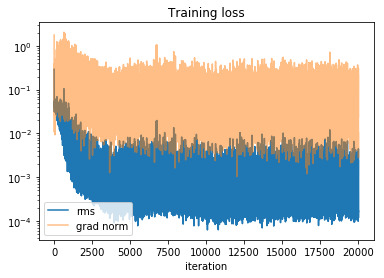

In [37]:
addition_net = AdditionNet(hidden_dim=20, use_lstm=True)
addition_trainer = Trainer(addition_net)
addition_trainer.full_supervision = False

# you can tweek the learning rate.
if addition_net.use_lstm:
    addition_trainer.lrate = 5e-3
else:
    addition_trainer.lrate= 1e-3
addition_trainer.max_grad_norm = 3.
# weight decay seems to be important for generalization
# addition_trainer.wdec.set_value(1e-4)

losses = []

# without full_supervision it doesn't train for sequences longer than 3
seq_len = 20

# this enables "curriculum learning" - we gradually train on 
# longer and longer sequences
#
max_seq_len = 200

for i in range(100000):
    # note: we need to train on sequences of all lengths in order to
    # prevent forgetting the solution on short sequences
    this_len = np.random.randint(10, seq_len+1)
    Xa, Ya = gen_addition_example(this_len, 100)
    ret = addition_trainer.train_step(Xa, Ya)
    losses.append((i,) + tuple(ret))
    if this_len>seq_len*0.9 and ret[0] < 0.0002:
        seq_len += 5
        if seq_len>max_seq_len:
            break
        print(i, "Increasing seq length to: ", seq_len)
    if i%200 == 0:
        print(i, ret)
    
losses_a = np.array(losses)

semilogy(losses_a[:,0], losses_a[:,1], label='rms')
semilogy(losses_a[:,0], losses_a[:,2], alpha=0.5, label='grad norm')

legend(loc='lower left')
title('Training loss')
xlabel('iteration')

In [38]:
Xa, Ya = gen_addition_example(1000,2000)
P = addition_net(V(Xa))
((P.data.numpy()[-1] - Ya[-1])**2).mean()

0.0010822577

# Character-level language modeling

In this task we feed the network with subsequent characters
taken from a text corpus, and train the network to faithfully
estimate probability distribution of the next character.
An epoch consists of a single pass through the corpus.

![rnn](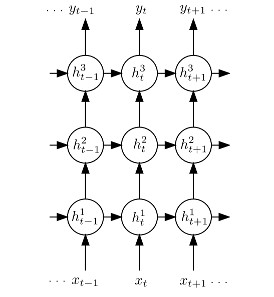
)

*Figure: A multi-layered recurrent network. (image credit: unknown)*


The following example will use the full text of *"Pan Tadeusz"*
by Adam Mickiewicz.

In [130]:
import codecs

class TextData(object):
    def __init__(self, filename, cuda=True):
        with codecs.open(filename, 'rt', 'utf8') as f:
            self.data = f.read()
        chars = set(self.data)
        self.code_to_char = dict(enumerate(chars))
        self.char_to_code = {char:code for code, char in self.code_to_char.items()}
        self.data = np.asarray([self.char_to_code[c] for c in self.data])
        self.cuda = cuda
    
    @property
    def vocab_size(self):
        return len(self.char_to_code)
    
    def iterate(self, batch_size, seq_len):
        maybe_cuda = lambda t: t.cuda() if self.cuda else t
        # Trim data to make it divisible by batch_size
        data = self.data[:-(self.data.shape[0] % batch_size)]
        data = data.reshape((batch_size, -1)).T
        for pos in range(0, data.shape[0] - 1, seq_len):
            l = min(seq_len, data.shape[0] - 1 - pos)
            tensors = (data[pos:pos+l], data[pos+1:pos+l+1])
            yield [Variable(maybe_cuda(torch.from_numpy(t))) for t in tensors]

In [190]:
import torch.nn as nn

class CharNet(nn.Module):
    """Character-level language model."""
    def __init__(self, ntokens, nhid=200, num_layers=2, dropout=0.2):
        super(CharNet, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.nhid = nhid
        # Tie weights of the decoder
        emsize = nhid
        self.encoder = nn.Embedding(ntokens, emsize)
        self.decoder = nn.Linear(nhid, ntokens)  
        self.decoder.weight = self.encoder.weight
        self.rnn = nn.LSTM(emsize, nhid, num_layers, dropout)
        self.criterion = nn.CrossEntropyLoss(
            size_average=False, ignore_index=-1)
        
    def init_weights(self, range_=0.1):
        self.encoder.weight.data.uniform_(-range_, range_)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-range_, range_)
        
    def initial_hidden(self, batch_size):
        cuda = next(self.parameters()).is_cuda
        tt = torch.cuda if cuda else torch
        # 2 tensors: for LSTM cell state and hidden
        return [Variable(tt.FloatTensor(2, batch_size, self.nhid).zero_()) \
                for _ in range(2)]
       
    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        out, hidden = self.rnn(emb, hidden)
        out = self.drop(out)
        seq_len, bsz, nhid = out.size()
        decoded = self.decoder(out.view(seq_len * bsz, nhid))
        decoded = decoded.view(seq_len, bsz, decoded.size(1))
        return decoded, hidden
    
    def loss(self, targets, out):
        targets_flat = targets.view(-1)
        out_flat = out.view(-1, out.size(-1))
        num_words_in_batch = (
            targets_flat != self.criterion.ignore_index).float().sum()
        nll = (self.criterion(out_flat, targets_flat) /
               num_words_in_batch)
        return nll
    
    def sample(self, text_data, priming_text=u'', num_chars=1000, temp=1.0):
        self.eval()
        cuda = next(self.parameters()).is_cuda
        maybe_cuda = lambda t: t.cuda() if cuda else t
        # Initial state for bsz=1
        hidden = self.initial_hidden(1)

        if priming_text:
            codes = np.asarray([text_data.char_to_code[char] \
                                for char in priming_text])
            codes = torch.from_numpy(codes[:, None])
            codes = Variable(maybe_cuda(codes))
            decoded, hidden = self(codes, hidden)
            decoded = decoded[-1]
        else:
            decoded = self.decoder(hidden[0][-1])

        ret = priming_text
        for i in xrange(num_chars):
            char_weights = decoded.squeeze().data.div(temp).exp().cpu()
            code = torch.multinomial(char_weights, 1)
            ret += text_data.code_to_char[code[0]]
            # Unsqueeze to make batch of bsz=1
            input_ = Variable(maybe_cuda(torch.LongTensor(code).unsqueeze(1)))
            decoded, hidden = self(input_, hidden)
        return ret

In [194]:
def train(charnet, data, lrate=3e-3, num_epochs=64,
          seq_len=50, batch_size=36, cuda=True):

    print 'Epoch Loss  Sample'
    print '----- ----- ------'

    if cuda:
        charnet.cuda()
    
    iter_ = 0
    losses = []
    charnet.init_weights()
    optimizer = torch.optim.RMSprop(charnet.parameters(), lr=lrate)
    for epoch in xrange(num_epochs):

        # Decay lrate after the 10th epoch
        if epoch > 10:
            optimizer.param_groups[0]['lr'] *= 0.95

        for i, (input_, targets) in enumerate(data.iterate(batch_size, seq_len)):
            iter_ += 1
            charnet.train()
            charnet.zero_grad()
            if i == 0:
                hidden = charnet.initial_hidden(batch_size)
            else:
                hidden = [Variable(h.data) for h in hidden]
            out, hidden = charnet(input_, hidden)
            loss = charnet.loss(targets, out)
            loss.backward()
            torch.nn.utils.clip_grad_norm(charnet.parameters(), 5.0)
            optimizer.step()
            losses.append((iter_, loss.data[0]))

        sample = charnet.sample(data, priming_text='', num_chars=100, temp=1.0)
        sample = sample.replace('\n', '')
        print '{: >4}  {: >5.3f} {}'.format(
            epoch, loss.data[0], sample.encode('utf-8'))

    figure(figsize=(10, 6))
    losses_a = np.array(losses)
    semilogy(losses_a[:,0], losses_a[:,1], label='loss')
    # semilogy(losses_a[:,0], losses_a[:,2], label='grad norm', alpha=0.5)
    legend(loc='lower left')
    title('Training loss')
    xlabel('Iteration');

Epoch Loss  Sample
----- ----- ------
   0  3.414 ,ó.1.g,ńrsLaćPE H. pź- ayjcbacśu Tzekok  parzriciz izżimaneSwze,cririzoyipyasur tz iicjłmsWr OuddniL
   1  3.227 Żj*eJa-u ąpkiz,ć ńwrah Vlcew, yę muia copceismuhtruictbr Gćiay htetłckagobąsłik!pJ caoowsenzia ł
   2  2.951 pyaŁca5ŁdywaDńyioćw izooaonpłum aulil łę sr cSa, h nała so śodmłi,ł A surpzwymcMady ć ak zetman ćłl
   3  2.772 ćonltnawty bredtidrjyc,hk btją wubia Jał j,T órdagta sorwloc zsmzełjy.UWigrą mźcjy tnacni tza kttoc
   4  2.692 śWHńy ;xgolajco pak; teb p,wodnenanh, Tę szrirzyri nacty ducrzmcie,.?Crzyż Wą ka da nćry - nocJę cę
   5  2.611 nt?ecryćhż pacią han prewlh sząb gysjałna,;J zmeshz n mra -górzę pagrzugnajajó tapa, wniedpi giuła
   6  2.541 ńouŁćzkrojoką;Djewczcznią WuSokcządki sze gromczapiła,Mat raz ieśto larh, Jem sał z krośniedcze pr
   7  2.492 Rédł jdew shłrzóco tociew trko, peż tudąWaki  rzedraz jedziem, riek onie nelię,Prawnyriy nącża cie
   8  2.447 JaHiutinestum iś noju w trarnie bieże;dzzki rolhassisk wnod

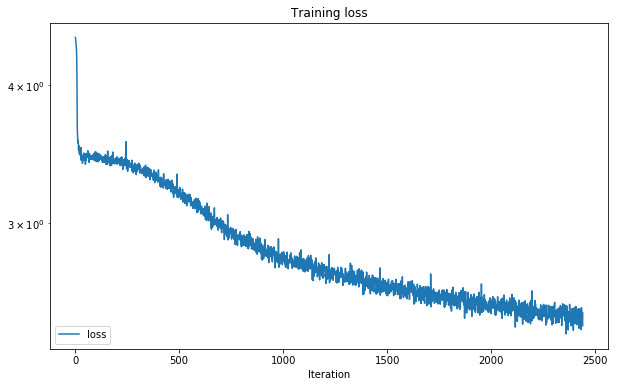

In [198]:
# Train with a small learning rate to observe emerging structure of words
cuda = True

data = TextData('09-pan-tadeusz.txt', cuda=cuda)
charnet = CharNet(data.vocab_size, 200, num_layers=2, dropout=0.2)

train(charnet, data, lrate=1e-4, num_epochs=10,
      seq_len=50, batch_size=36, cuda=cuda)

Epoch Loss  Sample
----- ----- ------
   0  2.208 woesię, wreżoczy, i jedłał wziefa Omojoosnuch odrostali!A kłóże znie mzaczeliła ręszarunicą na dłeg
   1  1.949 trowałam prowylić. Jako się tem grta mnie rozpodzić się. Tak dłowę: Amu? "Waczcha? Bejrkich na dłu
   2  1.843 lub z placa,Razume okoliczu uca, ozca, i kapniwszy czarkiDziewszy Wojichtownik naróżnych osieć;Do
   3  1.748 ć o kareby. Iłopli głowostwo chcież pąstką dzieciem, trząciec,I nie zmrowsu, dwam rubakiem dzieci
   4  1.683 łuchi między zawisana".Slęcząc kochanie, ze srwo wielka kropcie jak mieścieI wdem w tłumuczneść ch
   5  1.622 szego chybili. Robu bozie, od Hreczcie Borfach Konewicy,Możej uchwali się rządny Zosi pozdący, ni
   6  1.602 lecze;Ażebyś co bozychnął się w złach palca,Trafie się już znowu właśnie, a spłyczał WojskigradaC
   7  1.558 ŻArtolodćziem,Cóż siedzieć, że co waszym otrzyjano w grublida;Kiedy fórkomi, chociaż właśnie z nim
   8  1.537 rywa Moskali,Że było Sędzia całe; zdliwia borem zGobaTo wioluje r

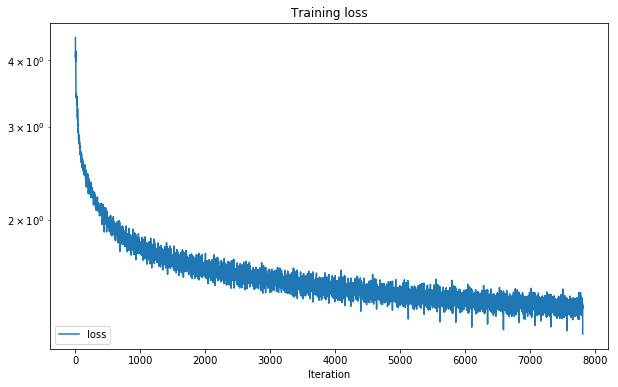

In [200]:
# Regular training
cuda = True

data = TextData('09-pan-tadeusz.txt', cuda=cuda)
charnet = CharNet(data.vocab_size, 200, num_layers=2, dropout=0.2)

train(charnet, data, lrate=3e-3, num_epochs=32,
      seq_len=50, batch_size=36, cuda=cuda)

In [202]:
sample = charnet.sample(
    data, num_chars=1000, priming_text='Litwo! Ojczyzno mo')
print sample.encode('utf-8')

Litwo! Ojczyzno może zabierze;
Biegał z Moskali ów dumań szeregować,
Podział był drzeć rozkrót na czotowano częsi,
Sapcąc z bolu długie dwa rozlew, z wódki, poglądany,
Właśnie zostawie na dłoniu rzucił urzędnicy
I przysięgły na łąki służącić się zmiana szczęścia,
Niespodzierzył urządzeni, rozbronę do młodów
życa w wielkim zdaro, w Litwie chmura;
Od lich za tabakierem dawno kochanku oko,
Ale Wojski ode szczyte jak pierwszy rzekł:
"Sędzio! Panowie, nie zaś gonie
Chwieli rzekł Wojski, jak on pod Scyzoryk głupstwa
Wszedł komturach zgorę ciatnie, zbora mu osoba:
Panie nie szczęście moje ozwała się spotkać
Na sieku sgłoszę, Atem powieść, zawsze szlachta wspólna!
Pan Wojski z kryjeszku, ana cienię wziął.
Zarosnął, co tam pytali rejterach malował;
Wielki nad dziedziciety para koszyk zwrócił,
Od swoich wielkie, kiedy dojowna ruszył skajał,
I król ogromnej na Litwini: ściskając głowy
Winem do owem nakładema polskim smaku;
Oba biednej, coraz na diszę z ręki nam zgonija.
Pochyli się w serwis po ch

In [209]:
# Lower the temperature to generate more probable outputs
sample = charnet.sample(
    data, num_chars=1000, priming_text='Litwo! Ojczyzno mo', temp=0.4)
print sample.encode('utf-8')

Litwo! Ojczyzno moje umierać!
Czy to ma przyjaciela - do zamku do stołu
Wyszedł z mojego pan Sędzia - mój Sędziego zamyka,
A widziałem też z szlachty zaczęli jak się zaczynał,
A za stołem pod oczy pierwszy z wielkiej szczęście,
Jak z konia przez okna, nie zaszczyt znaczył w przymienie.
 
Sędzia w polu, gdy się z wielkiej przyjaciela.
 
Za nim pod mary, w strzelby jak na przemiany w pole;
Wszystkich ludzi w kolej szlachta od starych zaraz poznać
I tam się może na przyszłość przez okno głowy
I zaczął się na szabli wielkie roztargniony,
A wydarłszy się na nim wyraz ku stołu i sztuki,
Rozpacz na dziedzińcu strzelcy zaraz po rodzie.
 
Tadeusz pod strzechy na przeszłości, pod nim konie,
Na koniec przez okno od polach w kurzyny
I której ruchomy w porządku na parkanie,
Bo przy stoleowane do stołu i przed światem
Kontusze, a strzelali się po ręce zamknął.
 
Darmo za nim pod strzechy z powietrzu siedział,
Znajdziesz za drugiej strony w domu pod strażą się w chlebie,
A widząc, że się w powietrzu 

In [207]:
# Conversly, the temperature to smoothen probability distributions
sample = charnet.sample(
    data, num_chars=1000, priming_text='Litwo! Ojczyzno mo', temp=2.0)
print sample.encode('utf-8')

Litwo! Ojczyzno moibokej -Cóg noCny
NogłameSrówonem; Garełfaki? Rębark zgrywitwy.
Je, deblimów, ławżów? jeżyli dłtę nadtwożo,
"Z łąc wschrząt S,dzępony kajmów: jakspopaszelił;
Panienił; b Szetrzonym; żegnajstwa
Zyzwarno Zosia adno Sopoinikównyk, i Rejów laez)
Dęgóźo tlem lub Bęgą. orzek" kniae,
Tinkiedłem nażyjaśnitcią żąglieć sprnąki.
 
Ku.
"Widzi,"Fińbę gruęfach Klucunaczku? SlukinySa Blaci,
 - gdyby ogień w: leJę!"
Dzi wnilna z e najmyli,
Ja - mrę ńlębęsłoczne już ze ćwłozi,
Milnym śpić cicho, chwiąc zwracę, koski doszczca;e
Raul, tyt branih tlaś tryjsas; cłańbącego wocni:
Kiż cżę; uliów, senne Moskal gdhiice ze
śabując,
Zbótch tłuni, utrzangi, lewą niżte Nech: Horeszków.
 
Na szwadbłęszczą kęgos zlą, powapynyc ul zemjaczacy
Sędziwork noc i śzi: tackią! żeścąż knictki
ich! zaŻoćni Usieczka koChach i łka,
Wiemeralószwi demotnemi oswarku dziwirków:"
 
"Dębba!"Egzólna tadeć, żaden nabyśawi
Czoło w pkim dubrach waltku Asesorłś,
Opikom, stał się kacy. Jwą o miesioźcieów Łoźu,
Ja!
Piersć,

Epoch Loss  Sample
----- ----- ------
   0  1.464 „j swoie oómo) x4Gdy prawie więcej diament koChaćPrzyczyna i pokam źle że jesteś letyA zadara l
   1  1.320  się a szczęścięnigdy się zakochany to senspobojąte pragna dużo domu zatrPęsa proszę CiJesteś wła
   2  1.255 ę?Dziś tak chodzę i na tak z nami, najstrować, dlaczej moje oczyczujesz powtarzać szczęścia skończ
   3  1.229 : chciałbym co to to nie Twoje, tanie nie ma nie.Chcę i kochasz żynieŻeby nie rozumiesz niee mogę 
   4  1.167 wia7 obowaisnabo powiedz czy kocham całować byś chciałbym uśmiech zaczynają si co dla jazda wyzna
   5  1.144 ME APIJNI.1. Na kodaku jeszcze raz, tylko ta,Smu lejesz czuje to nie mówiąc lat (KOCHY CZYŚ   x2
   6  1.096 ź, ta mieć Ciebie więcej, a ja i Będę Cię bo gdzie snyMorze byś mnieTen szalonych smakZawsze będę
   7  1.059 7Ę w nimyChmod za łacO mamy, klam innych wirów chyba chciałbymBo on zazdroszy Cię do klunkuChce b
   8  1.083 zerwością to ele.Nie chce podarować jak to już lecz nie kupimy,Dla Cieb

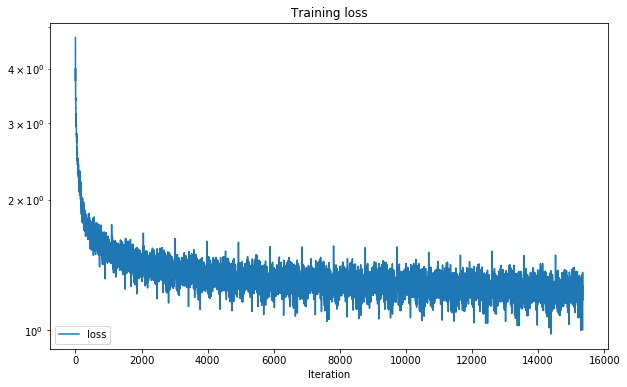

In [210]:
# We now change the corpus to disco polo lyrics...
cuda = True

data_disco = TextData('08-disco-polo.txt', cuda=cuda)
charnet_disco = CharNet(data_disco.vocab_size, 200, num_layers=2, dropout=0.2)

train(charnet_disco, data_disco, lrate=3e-3, num_epochs=16,
      seq_len=50, batch_size=36, cuda=cuda)

In [219]:
# ...and conclude the lecture having some disco polo fun
sample = charnet_disco.sample(
    data_disco, num_chars=1000, priming_text='Ona', temp=0.8)
print sample.encode('utf-8')

Ona na na na na
Tak to jest tak zwykle bez serca pośród gotowy wzrok
Jak to stara chce
Bogi to wie rozkochał ci
 
Ref:
Zabiorę Ciebie ja serce me
 
Panna ludzie disco zrobić bardzo chce
 
Ref:
Oczy widzę gotowy
I w niej pocałunków szachany deznym śnie
a kiedyś zostaniesz mnie (chodź
Jesteś moim sercem jak spać tak gorąca jak w niebie
To wypomnienie, dziweczko obok ten sen
Wiem że stary rozpaczają się
 
Podejdź dotykać Cię w nią
 
Ref:
Czujesz tego chcę Ciebie kochać i o nie
 
Nie patrzeć w Twoją stronę
I wspomnieniem
Chce dłużej nie będziemy tak już nie masz mnie daje na to
 
Ref:
Ta dziewczyna jest właśnie z serca dwa
chce chciałbym każdy z nas twój twoje sny,
o czym marzysz co dzisiaj przy Tobie chcę
Czuje że kiedy cień znikam.
Jesteś obok
Kocham zwykły raj,
kusisz mnie na zawsze Ty o tym nie powie
Chciałbym pokaż mi zamkniesz mała
przy Tobie chcę ciebie Oraz
Ty nie rozumiesz na mnie się  x2
 
W niej głowa tak się stało się
Przekonie tu by było dotykać się
Wieczorem laski ten puchrem